# Содержание

1. [Подключаемые библиотеки](#scrollTo=ODd8MpOtk0Oj&line=1&uniqifier=1)
2. [Импорт отзывов](#scrollTo=5TbQnhsalDOa&line=1&uniqifier=1)
3. [Предварительный анализ](#scrollTo=sTh-ANl2rH6A&line=1&uniqifier=1)
4. [Подготовка к разведочному анализу данных](#scrollTo=srpr-e0cmrB2&line=1&uniqifier=1)
5. [EDA](#scrollTo=ZgW0Ih4JjKGU&line=1&uniqifier=1)
  * [Score](#scrollTo=d2DacjOBnvDJ&line=1&uniqifier=1)
  * [Топ-15 по числу отзывов](#scrollTo=g8Eck6tqonHn&line=1&uniqifier=1)
  * [Средний рейтинг топовых банков](#scrollTo=1UO_imDlB8CH&line=1&uniqifier=1)
  * [Динамика среднего рейтинга банков по месяцам](#scrollTo=KKqZaehIXLoL&line=2&uniqifier=1)
  * [Странности](#scrollTo=4GUNHtqU9VGJ&line=1&uniqifier=1)
  * [Зависимость положительности/отрицательности от длины отзыва](#scrollTo=5pywmEUgCC3Z&line=1&uniqifier=1)
  * [Распределение отзывов по месяцам, дням недели, времени суток](#scrollTo=x7QJM6oqMGUZ&line=1&uniqifier=1)
6. [Обучение и тестирование моделей](#scrollTo=mCKOOcKYJa8D&line=1&uniqifier=1)
  * [Препроцессинг](#scrollTo=X_CpA0v7Ke1t&line=1&uniqifier=1)
  * [Векторизация tf-idf](#scrollTo=OiegwzOC_0_j&line=1&uniqifier=1)
  * [Разделение на трейн и тест](#scrollTo=G3rfjeYH4ve2&line=1&uniqifier=1)
  * [Логиcтическая регрессия (baseline)](#scrollTo=nbLv0Lr4DPgt&line=1&uniqifier=1)
  * [CatBoost и GridSearch](#scrollTo=TlVuVh60x7uQ&line=1&uniqifier=1)
  * [Результаты](#scrollTo=TBqYxRPhSkqF&line=1&uniqifier=1)
7. [Снижение размерности признакового пространства](#scrollTo=1paSPLYloEVf&line=1&uniqifier=1)
8. [Характерные признаки для классов](#scrollTo=1aR6CQ1VX1_0&line=1&uniqifier=1)

# Анализ отзывов на банки

В данных представлены отзывы на банки с сайта [banki.ru](https://www.banki.ru/)
- body - сам отзыв
- title - название отзыва
- rating - оценка по отзыву, варьируется от 1 до 5
- bank_name - название банка
- date - дата публикации отзыва

Необходимо EDA (Exploratory Data Analysis) по этим данным и сделать несколько выводов (приветствуются визуализации):
- назвать топ-15 банков по числу отзывов
- какой банк из числа топ-15 по отзывов имеет самый высокий средний рейтинг?
- сделать выводы об изменении среднего рейтинга банков по месяцам из топ-5 банков по числу отзывов
- нет ли в данных в целом каких-то странностей на ваш взгляд?
- дополнительный EDA на ваше усмотрение, возможные интересные наблюдения

Необходимо выбрать метрику и построить бинарный классификатор отзывов, добившись при этом лучшей метрики на валидационной выборке (отзывы >=3 считать положительными, <3 - отрицательными)

Будет плюсом визуализация результатов работы модели (ответ на вопрос: почему построенная модель считает этот отзыв положительным или отрицательным?)

In [ ]:
import warnings
warnings.filterwarnings('ignore')

## Подключаемые библиотеки

In [ ]:
#!pip install pymorphy3
#!pip install catboost
#!pip install wordcloud

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.2/53.2 kB 876.6 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.4/8.4 MB 28.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 8.8 MB/s eta 0:00:00


In [ ]:
# вспомогательные
import numpy as np
import pandas as pd
import re
import ast

# графики
from matplotlib import pyplot as plt
from matplotlib import patches
import seaborn as sns

# предобработка
import pymorphy3
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from collections import Counter
from sklearn.feature_extraction.text import TfidfVectorizer

# моделирование
from sklearn.model_selection import train_test_split #, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, roc_auc_score
from catboost import CatBoostClassifier, Pool #, cv

# анализ важности
from wordcloud import WordCloud

In [ ]:
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

## Импорт отзывов

In [ ]:
reviews = pd.read_csv('data/parsed_reviews3.csv')

In [ ]:
reviews.head()

,body,title,rating,bank_name,date
0,&lt;p&gt;Добрый день&lt;/p&gt;\r\n&lt;p&gt;пиш...,Заблокировали средства,1,Еком Банк,2023-01-03 12:46:11
1,&lt;p&gt;При возврате просроченной задолженнос...,Возврат просроченной задолженномти,1,Тинькофф Банк,2023-01-03 12:31:46
2,&lt;p&gt;07.09.22 ю была оформлена кредитная к...,"Ошибочное начисление комиссии, затягивание про...",1,Банк Открытие,2023-01-03 12:23:11
3,&lt;p&gt;Новый год начинается с приятностей)&l...,Клиентоориентиванность 10 из 10,5,Тинькофф Банк,2023-01-03 12:16:07
4,&lt;p&gt;Увидела на сайте Газпромбанка акцию с...,Как Газпромбанк обманывает клиентов с акционны...,1,Газпромбанк,2023-01-03 12:12:36


## Предварительный анализ

In [ ]:
print(f'Размер всего датасета = {reviews.shape}')

Размер всего датасета = (92735, 5)


Как выглядит информация об отзыве

In [ ]:
first_review = reviews.iloc[0]
print(f"Title:\n{first_review['title']}\nBody:\n{first_review['body']}\nBank: {first_review['bank_name']}\nRating: {first_review['rating']}\nDate: {first_review['date']}")

Title:
Заблокировали средства
Body:
&lt;p&gt;Добрый день&lt;/p&gt;
&lt;p&gt;пишу сюда для более скорого разрешения вопроса &lt;/p&gt;
&lt;p&gt;Пополнил через Юмани Озон банк&lt;/p&gt;
&lt;p&gt;после чего вывести деньги не дал, сославшись на сомнительные операции(понимаю, могло так показаться)&lt;/p&gt;
&lt;p&gt;просто озон удобен тем что можно пополнить его через QIWI и Юмани без комиссии, за что ценю&lt;/p&gt;
&lt;p&gt;документы предоставил, причины переводов тоже&lt;/p&gt;
&lt;p&gt;надеюсь на разблокировку, если не для переводов, то хотя бы для оплаты товаров&lt;/p&gt;
&lt;p&gt;для привлечения внимания пока ставлю 1&lt;/p&gt;
&lt;p&gt;после решения вопроса поставлю 5&lt;/p&gt;
Bank: Еком Банк
Rating: 1
Date: 2023-01-03 12:46:11


В самом отзыве видны html-тэги

In [ ]:
reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 92735 entries, 0 to 92734
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   body       92735 non-null  object
 1   title      92735 non-null  object
 2   rating     92735 non-null  int64 
 3   bank_name  92735 non-null  object
 4   date       92735 non-null  object
dtypes: int64(1), object(4)
memory usage: 3.5+ MB


Нет пропущенных значений

In [ ]:
reviews.nunique()

body         91832
title        54505
rating           5
bank_name      157
date         91059
dtype: int64

Всего в выборке имеется отзывы о 157 банках.

Возможно имеются повторяющиеся строки.

In [ ]:
duplicated_reviews_1 = reviews[reviews.duplicated()]
duplicated_reviews_1

,body,title,rating,bank_name,date
899,&lt;p&gt;Обратился 3 декабря в районе 19 часов...,открытие счёта и получение банковской карты,5,Хоум Кредит Банк,2022-12-30 16:16:13
997,&lt;p&gt;С самого открытия являемся клиентами ...,"Сняли деньги за перевод физ.лицу, а услугу не ...",1,Норвик Банк,2022-12-30 14:06:33
1611,&lt;p&gt;22.12.2022 в чате своего ЛК мобильног...,Отсутствие информации о порядке конвертации ва...,2,Росбанк,2022-12-29 15:03:06
2502,"&lt;p&gt;Оформлял рассрочку на телефон, в мага...",Лучший кредитный банк,5,Хоум Кредит Банк,2022-12-28 13:44:16
2504,&lt;p&gt;28 декабря я посетил банк МКБ по адре...,Отличное обслуживание,5,Московский Кредитный Банк,2022-12-28 13:42:41
...,...,...,...,...,...
43911,"&lt;p&gt;Здравствуйте, возникла проблема с пол...","Деньги списались, но не дошли!",1,Юнистрим,2022-11-11 10:17:30
63490,"&lt;p&gt;Хочу оставитт отзыв о ТИНЬКОФ БАНК , ...",Благодарность,5,Тинькофф Банк,2022-10-28 13:35:38
77358,"&lt;p&gt;Добрый вечер, сегодня я хотел бы расс...",Моё мнение о банке,5,Тинькофф Банк,2022-10-20 18:33:45
85895,Здравствуйте! Хочу поблагодарить сотрудника Хо...,Оформление онлайн потребительского кредита,5,Хоум Кредит Банк,2022-09-25 18:48:43


Удалим их

In [ ]:
reviews = reviews.drop_duplicates()

In [ ]:
reviews.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 92673 entries, 0 to 92734
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   body       92673 non-null  object
 1   title      92673 non-null  object
 2   rating     92673 non-null  int64 
 3   bank_name  92673 non-null  object
 4   date       92673 non-null  object
dtypes: int64(1), object(4)
memory usage: 4.2+ MB


In [ ]:
reviews.nunique()

body         91832
title        54505
rating           5
bank_name      157
date         91059
dtype: int64

Довольно часто у разных отзывов одинаковое содержание или заголовок. Будет логично удалить отзывы с одинаковыми содержанием, заголовком, рейтингом и банком.

In [ ]:
duplicated_reviews_2 = reviews[reviews.duplicated(subset=['body', 'title', 'rating', 'bank_name'])]
duplicated_reviews_2

,body,title,rating,bank_name,date
305,&lt;p&gt;Здравствуйте🙂Хочу поблагодарить Совко...,Быстрое решение моего вопроса по кредиту плюс ...,5,Совкомбанк,2023-01-01 18:01:42
306,&lt;p&gt;Здравствуйте🙂Хочу поблагодарить Совко...,Быстрое решение моего вопроса по кредиту плюс ...,5,Совкомбанк,2023-01-01 18:01:40
2393,&lt;p&gt;В Совкомбанке очень хорошо обращаются...,Рекомендую всем,5,Белгородсоцбанк,2022-12-28 15:06:54
3059,&lt;p&gt;Сегодня посетила отделение банка по а...,Обслуживание,5,Совкомбанк,2022-12-27 18:56:37
3647,&lt;p&gt;Являюсь клиентом банка Хоум Кредит ле...,Спасибо за карту рассрочки,5,Хоум Кредит Банк,2022-12-26 21:32:45
...,...,...,...,...,...
70036,"&lt;p&gt;Отличная работа поддержки, благодарно...",Тинькофф,5,Тинькофф Банк,2022-10-27 14:44:18
70329,&lt;p&gt;Случайно перевёл деньги не тому челов...,Благодарность банку Тинькофф,5,Тинькофф Банк,2022-10-27 14:31:43
70672,&lt;p&gt;Что мне больше всего нравится в банке...,Лучший банк,5,Тинькофф Банк,2022-10-27 13:54:11
70881,"&lt;p&gt;Хороший банк, качественное обслуживан...",Дибетовая карта Тинькофф Блэк,5,Тинькофф Банк,2022-10-27 13:19:23


In [ ]:
reviews = reviews.drop_duplicates(subset=['body', 'title', 'rating', 'bank_name'])

In [ ]:
reviews.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 92446 entries, 0 to 92734
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   body       92446 non-null  object
 1   title      92446 non-null  object
 2   rating     92446 non-null  int64 
 3   bank_name  92446 non-null  object
 4   date       92446 non-null  object
dtypes: int64(1), object(4)
memory usage: 4.2+ MB


In [ ]:
reviews.nunique()

body         91832
title        54505
rating           5
bank_name      157
date         90848
dtype: int64

Исследуем удаленные строки

In [ ]:
duplicated_reviews = pd.concat([duplicated_reviews_1, duplicated_reviews_2])

In [ ]:
duplicated_reviews.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 289 entries, 899 to 71892
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   body       289 non-null    object
 1   title      289 non-null    object
 2   rating     289 non-null    int64 
 3   bank_name  289 non-null    object
 4   date       289 non-null    object
dtypes: int64(1), object(4)
memory usage: 13.5+ KB


In [ ]:
duplicated_reviews.nunique()

body         250
title        211
rating         5
bank_name     21
date         288
dtype: int64

Узнаем, в каких банках много повторяющихся отзывов

In [ ]:
duplicated_reviews['bank_name'].value_counts()

Тинькофф Банк                              204
Хоум Кредит Банк                            23
Совкомбанк                                  20
Модульбанк                                   9
Россельхозбанк                               5
ВТБ                                          5
СберБанк                                     4
Росбанк                                      3
Московский Кредитный Банк                    2
Русский Стандарт                             2
Уральский Банк Реконструкции и Развития      2
Норвик Банк                                  1
Почта Банк                                   1
Альфа-Банк                                   1
Азиатско-Тихоокеанский Банк                  1
БКС Банк                                     1
Юнистрим                                     1
Белгородсоцбанк                              1
Газпромбанк                                  1
Банк Уралсиб                                 1
Цифра банк                                   1
Name: bank_na

Взглянем на повторяющиеся дубликаты

In [ ]:
tmp_df = duplicated_reviews[duplicated_reviews.duplicated(subset='body')]
tmp_df[tmp_df['bank_name']=='Тинькофф Банк']

,body,title,rating,bank_name,date
24630,&lt;p&gt;Картой Тинькофф блэк пользуюсь уже да...,Офигенная карта,5,Тинькофф Банк,2022-12-06 18:01:56
26961,&lt;p&gt;Пользуюсь дебетовой карты Тинькофф Ба...,Дебетовая карта,5,Тинькофф Банк,2022-12-04 18:01:53
32835,&lt;p&gt;Добрый вечер! Хочу рассказать вам про...,Москва,5,Тинькофф Банк,2022-11-25 18:01:55
37675,&lt;p&gt;Хотелось бы рассказать о службе подде...,Служба поддержки Tinkoff,5,Тинькофф Банк,2022-11-19 18:01:51
37676,&lt;p&gt;Хотелось бы рассказать о службе подде...,Служба поддержки Tinkoff,5,Тинькофф Банк,2022-11-19 18:01:46
37677,&lt;p&gt;Хотелось бы рассказать о службе подде...,Служба поддержки Tinkoff,5,Тинькофф Банк,2022-11-19 18:01:44
42243,&lt;p&gt;Хочу выразить благодарность сотрудник...,Благодарность,5,Тинькофф Банк,2022-11-13 10:49:55
52752,"&lt;p&gt;Отличный банк, всем советую, обращалс...",Тинькофф отличный банк,5,Тинькофф Банк,2022-11-02 20:42:42
52755,"&lt;p&gt;Отличный банк, всем советую, обращалс...",Тинькофф отличный банк,5,Тинькофф Банк,2022-11-02 20:41:52
52758,"&lt;p&gt;Отличный банк, всем советую, обращалс...",Тинькофф отличный банк,5,Тинькофф Банк,2022-11-02 20:40:52


Можно заметить, что дублирующиеся отзывы чаще всего единичны и близки по времени публикации.

Оставшиеся отзывы могут иметь одинаковое содержание, но относиться к разным банкам, иметь разные заголовки или даже оценки $-$ их следует пока что оставить.

Рассмотрим распределение оценок

In [ ]:
reviews['rating'].value_counts()

5    66994
1    18410
4     3453
2     2409
3     1180
Name: rating, dtype: int64

## Подготовка к разведочному анализу данных

Добавим колонку `score` для оценки тональности отзыва
* 1 $-$ положительный отзыв
* 0 $-$ отрицательный отзыв

In [ ]:
reviews['score'] = reviews['rating'].apply(lambda rating: 0 if rating < 3 else 1)
reviews.head()

,body,title,rating,bank_name,date,score
0,&lt;p&gt;Добрый день&lt;/p&gt;\r\n&lt;p&gt;пиш...,Заблокировали средства,1,Еком Банк,2023-01-03 12:46:11,0
1,&lt;p&gt;При возврате просроченной задолженнос...,Возврат просроченной задолженномти,1,Тинькофф Банк,2023-01-03 12:31:46,0
2,&lt;p&gt;07.09.22 ю была оформлена кредитная к...,"Ошибочное начисление комиссии, затягивание про...",1,Банк Открытие,2023-01-03 12:23:11,0
3,&lt;p&gt;Новый год начинается с приятностей)&l...,Клиентоориентиванность 10 из 10,5,Тинькофф Банк,2023-01-03 12:16:07,1
4,&lt;p&gt;Увидела на сайте Газпромбанка акцию с...,Как Газпромбанк обманывает клиентов с акционны...,1,Газпромбанк,2023-01-03 12:12:36,0


Преобразуем в формат даты столбец `date` и выделим дополнительные признаки (месяц, день недели)

In [ ]:
reviews['date'] = pd.to_datetime(reviews['date'])

In [ ]:
reviews['date'].dt.year.unique()

array([2023, 2022])

In [ ]:
reviews['month'] = reviews['date'].dt.strftime('%Y-%m')
reviews.head()

,body,title,rating,bank_name,date,score,month
0,&lt;p&gt;Добрый день&lt;/p&gt;\r\n&lt;p&gt;пиш...,Заблокировали средства,1,Еком Банк,2023-01-03 12:46:11,0,2023-01
1,&lt;p&gt;При возврате просроченной задолженнос...,Возврат просроченной задолженномти,1,Тинькофф Банк,2023-01-03 12:31:46,0,2023-01
2,&lt;p&gt;07.09.22 ю была оформлена кредитная к...,"Ошибочное начисление комиссии, затягивание про...",1,Банк Открытие,2023-01-03 12:23:11,0,2023-01
3,&lt;p&gt;Новый год начинается с приятностей)&l...,Клиентоориентиванность 10 из 10,5,Тинькофф Банк,2023-01-03 12:16:07,1,2023-01
4,&lt;p&gt;Увидела на сайте Газпромбанка акцию с...,Как Газпромбанк обманывает клиентов с акционны...,1,Газпромбанк,2023-01-03 12:12:36,0,2023-01


In [ ]:
np.unique(reviews['month'].values)

array(['2022-09', '2022-10', '2022-11', '2022-12', '2023-01'],
      dtype=object)

In [ ]:
reviews['dow'] = reviews['date'].dt.day_name()
reviews.head()

,body,title,rating,bank_name,date,score,month,dow
0,&lt;p&gt;Добрый день&lt;/p&gt;\r\n&lt;p&gt;пиш...,Заблокировали средства,1,Еком Банк,2023-01-03 12:46:11,0,2023-01,Tuesday
1,&lt;p&gt;При возврате просроченной задолженнос...,Возврат просроченной задолженномти,1,Тинькофф Банк,2023-01-03 12:31:46,0,2023-01,Tuesday
2,&lt;p&gt;07.09.22 ю была оформлена кредитная к...,"Ошибочное начисление комиссии, затягивание про...",1,Банк Открытие,2023-01-03 12:23:11,0,2023-01,Tuesday
3,&lt;p&gt;Новый год начинается с приятностей)&l...,Клиентоориентиванность 10 из 10,5,Тинькофф Банк,2023-01-03 12:16:07,1,2023-01,Tuesday
4,&lt;p&gt;Увидела на сайте Газпромбанка акцию с...,Как Газпромбанк обманывает клиентов с акционны...,1,Газпромбанк,2023-01-03 12:12:36,0,2023-01,Tuesday


Дополнительно добавим столбец с временем суток и с типом дня

In [ ]:
reviews['tod'] = pd.cut(reviews['date'].dt.hour,
                          bins=[0, 6, 11, 16, 23],
                          labels=['Night', 'Morning', 'Afternoon', 'Evening'],
                          include_lowest=True)
reviews.head()

,body,title,rating,bank_name,date,score,month,dow,tod
0,&lt;p&gt;Добрый день&lt;/p&gt;\r\n&lt;p&gt;пиш...,Заблокировали средства,1,Еком Банк,2023-01-03 12:46:11,0,2023-01,Tuesday,Afternoon
1,&lt;p&gt;При возврате просроченной задолженнос...,Возврат просроченной задолженномти,1,Тинькофф Банк,2023-01-03 12:31:46,0,2023-01,Tuesday,Afternoon
2,&lt;p&gt;07.09.22 ю была оформлена кредитная к...,"Ошибочное начисление комиссии, затягивание про...",1,Банк Открытие,2023-01-03 12:23:11,0,2023-01,Tuesday,Afternoon
3,&lt;p&gt;Новый год начинается с приятностей)&l...,Клиентоориентиванность 10 из 10,5,Тинькофф Банк,2023-01-03 12:16:07,1,2023-01,Tuesday,Afternoon
4,&lt;p&gt;Увидела на сайте Газпромбанка акцию с...,Как Газпромбанк обманывает клиентов с акционны...,1,Газпромбанк,2023-01-03 12:12:36,0,2023-01,Tuesday,Afternoon


In [ ]:
reviews['day_type'] = reviews['dow'].apply(lambda day: "Weekend" if day in ["Saturday", "Sunday"] else "Weekday")
reviews.head()

,body,title,rating,bank_name,date,score,month,dow,tod,day_type
0,&lt;p&gt;Добрый день&lt;/p&gt;\r\n&lt;p&gt;пиш...,Заблокировали средства,1,Еком Банк,2023-01-03 12:46:11,0,2023-01,Tuesday,Afternoon,Weekday
1,&lt;p&gt;При возврате просроченной задолженнос...,Возврат просроченной задолженномти,1,Тинькофф Банк,2023-01-03 12:31:46,0,2023-01,Tuesday,Afternoon,Weekday
2,&lt;p&gt;07.09.22 ю была оформлена кредитная к...,"Ошибочное начисление комиссии, затягивание про...",1,Банк Открытие,2023-01-03 12:23:11,0,2023-01,Tuesday,Afternoon,Weekday
3,&lt;p&gt;Новый год начинается с приятностей)&l...,Клиентоориентиванность 10 из 10,5,Тинькофф Банк,2023-01-03 12:16:07,1,2023-01,Tuesday,Afternoon,Weekday
4,&lt;p&gt;Увидела на сайте Газпромбанка акцию с...,Как Газпромбанк обманывает клиентов с акционны...,1,Газпромбанк,2023-01-03 12:12:36,0,2023-01,Tuesday,Afternoon,Weekday


**Будем считать заголовок частью отзыва**

In [ ]:
reviews['review'] = reviews['title'].str.cat(reviews['body'], sep=' ')
del reviews['body']
del reviews['title']
reviews.head()

,rating,bank_name,date,score,month,dow,tod,day_type,review
0,1,Еком Банк,2023-01-03 12:46:11,0,2023-01,Tuesday,Afternoon,Weekday,Заблокировали средства &lt;p&gt;Добрый день&lt...
1,1,Тинькофф Банк,2023-01-03 12:31:46,0,2023-01,Tuesday,Afternoon,Weekday,Возврат просроченной задолженномти &lt;p&gt;Пр...
2,1,Банк Открытие,2023-01-03 12:23:11,0,2023-01,Tuesday,Afternoon,Weekday,"Ошибочное начисление комиссии, затягивание про..."
3,5,Тинькофф Банк,2023-01-03 12:16:07,1,2023-01,Tuesday,Afternoon,Weekday,Клиентоориентиванность 10 из 10 &lt;p&gt;Новый...
4,1,Газпромбанк,2023-01-03 12:12:36,0,2023-01,Tuesday,Afternoon,Weekday,Как Газпромбанк обманывает клиентов с акционны...


Далее хотим добавить информацию о фактической длине отзыва. Но прежде всего следует избавиться от html-тегов

In [ ]:
def clean_html(text):
    cleaned_text = re.sub('&lt;.*?&gt;', '', text) # удаляем тэги
    cleaned_text = re.sub(r'[ \n\r\xa0\t]+', ' ', cleaned_text) # удаляем специальные символы и пробелы
    return cleaned_text

In [ ]:
reviews['review'] = reviews['review'].apply(clean_html)
reviews.head()

,rating,bank_name,date,score,month,dow,tod,day_type,review
0,1,Еком Банк,2023-01-03 12:46:11,0,2023-01,Tuesday,Afternoon,Weekday,Заблокировали средства Добрый день пишу сюда д...
1,1,Тинькофф Банк,2023-01-03 12:31:46,0,2023-01,Tuesday,Afternoon,Weekday,Возврат просроченной задолженномти При возврат...
2,1,Банк Открытие,2023-01-03 12:23:11,0,2023-01,Tuesday,Afternoon,Weekday,"Ошибочное начисление комиссии, затягивание про..."
3,5,Тинькофф Банк,2023-01-03 12:16:07,1,2023-01,Tuesday,Afternoon,Weekday,Клиентоориентиванность 10 из 10 Новый год начи...
4,1,Газпромбанк,2023-01-03 12:12:36,0,2023-01,Tuesday,Afternoon,Weekday,Как Газпромбанк обманывает клиентов с акционны...


In [ ]:
reviews.iloc[0]['review']

'Заблокировали средства Добрый день пишу сюда для более скорого разрешения вопроса Пополнил через Юмани Озон банк после чего вывести деньги не дал, сославшись на сомнительные операции(понимаю, могло так показаться) просто озон удобен тем что можно пополнить его через QIWI и Юмани без комиссии, за что ценю документы предоставил, причины переводов тоже надеюсь на разблокировку, если не для переводов, то хотя бы для оплаты товаров для привлечения внимания пока ставлю 1 после решения вопроса поставлю 5'

In [ ]:
reviews['review_size'] = reviews['review'].apply(len)
reviews.head()

,rating,bank_name,date,score,month,dow,tod,day_type,review,review_size
0,1,Еком Банк,2023-01-03 12:46:11,0,2023-01,Tuesday,Afternoon,Weekday,Заблокировали средства Добрый день пишу сюда д...,502
1,1,Тинькофф Банк,2023-01-03 12:31:46,0,2023-01,Tuesday,Afternoon,Weekday,Возврат просроченной задолженномти При возврат...,445
2,1,Банк Открытие,2023-01-03 12:23:11,0,2023-01,Tuesday,Afternoon,Weekday,"Ошибочное начисление комиссии, затягивание про...",1178
3,5,Тинькофф Банк,2023-01-03 12:16:07,1,2023-01,Tuesday,Afternoon,Weekday,Клиентоориентиванность 10 из 10 Новый год начи...,938
4,1,Газпромбанк,2023-01-03 12:12:36,0,2023-01,Tuesday,Afternoon,Weekday,Как Газпромбанк обманывает клиентов с акционны...,570


Удалим оставшиеся дубликаты

In [ ]:
reviews[reviews.duplicated(subset=['review', 'rating', 'bank_name'])]

,rating,bank_name,date,score,month,dow,tod,day_type,review,review_size
3971,5,Совкомбанк,2022-12-26 13:39:28,1,2022-12,Monday,Afternoon,Weekday,Возврат комиссии Являюсь постоянным клиентом Б...,1029
5802,1,Россельхозбанк,2022-12-22 15:52:05,0,2022-12,Thursday,Afternoon,Weekday,Блокировка дебетовой карты Добрый день! 29.11....,1459
8191,5,Совкомбанк,2022-12-19 14:40:59,1,2022-12,Monday,Afternoon,Weekday,Благодарственное письмо Хочу выразить огромную...,455
17834,5,Тинькофф Банк,2022-12-09 16:00:40,1,2022-12,Friday,Afternoon,Weekday,Отличный банк на мой взгляд банк Тинькофф один...,379
28457,5,Хоум Кредит Банк,2022-12-01 23:06:00,1,2022-12,Thursday,Evening,Weekday,Отличное отношение банка к клиентам Возникла н...,1229
30957,5,Тинькофф Банк,2022-11-29 08:51:14,1,2022-11,Tuesday,Morning,Weekday,Положительный отзыв о Tinkoff Bank Хочу подели...,361
35560,5,Тинькофф Банк,2022-11-22 20:25:34,1,2022-11,Tuesday,Evening,Weekday,"Одобрили кредитную карту Привет, хочу поделить...",1399
37455,5,Тинькофф Банк,2022-11-20 09:22:23,1,2022-11,Sunday,Morning,Weekend,Банкоматы Тинькофф Недавно необходимо было сня...,774
37948,5,Тинькофф Банк,2022-11-19 11:42:57,1,2022-11,Saturday,Morning,Weekend,"Благодарность Добрый день, я бы хотел выразить...",567
38287,1,Тинькофф Банк,2022-11-18 17:57:37,0,2022-11,Friday,Evening,Weekday,"Стоило оно того? Начну свою историю с того,что...",1820


In [ ]:
reviews = reviews.drop_duplicates(subset=['review', 'rating', 'bank_name'])

In [ ]:
print(len(reviews))
reviews.nunique()

92406


rating             5
bank_name        157
date           90808
score              2
month              5
dow                7
tod                4
day_type           2
review         92399
review_size     3249
dtype: int64

In [ ]:
reviews = reviews[['bank_name', 'review', 'review_size', 'rating', 'score', 'date', 'month', 'dow', 'day_type', 'tod']]
reviews.head()

,bank_name,review,review_size,rating,score,date,month,dow,day_type,tod
0,Еком Банк,Заблокировали средства Добрый день пишу сюда д...,502,1,0,2023-01-03 12:46:11,2023-01,Tuesday,Weekday,Afternoon
1,Тинькофф Банк,Возврат просроченной задолженномти При возврат...,445,1,0,2023-01-03 12:31:46,2023-01,Tuesday,Weekday,Afternoon
2,Банк Открытие,"Ошибочное начисление комиссии, затягивание про...",1178,1,0,2023-01-03 12:23:11,2023-01,Tuesday,Weekday,Afternoon
3,Тинькофф Банк,Клиентоориентиванность 10 из 10 Новый год начи...,938,5,1,2023-01-03 12:16:07,2023-01,Tuesday,Weekday,Afternoon
4,Газпромбанк,Как Газпромбанк обманывает клиентов с акционны...,570,1,0,2023-01-03 12:12:36,2023-01,Tuesday,Weekday,Afternoon


Можно переходить к EDA

## EDA

### Score

Для начала изучим целевую переменную

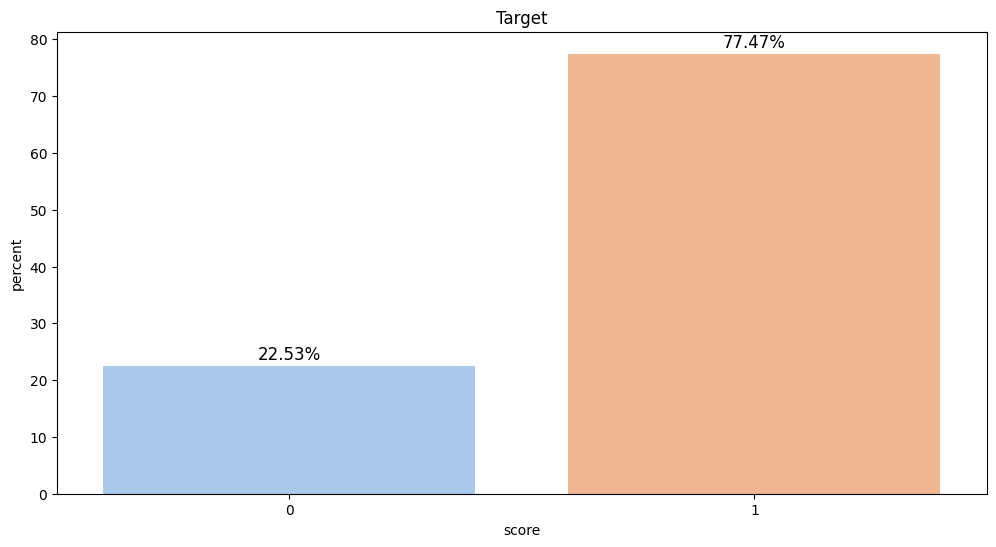

In [ ]:
target = reviews['score'].value_counts(normalize=True).mul(100).rename('percent').reset_index()

plt.figure(figsize=(12, 6))
ax = sns.barplot(x='index', y='percent', data=target, palette=sns.color_palette("pastel"))

for p in ax.patches:
    percent = f'{p.get_height():.2f}%'
    ax.annotate(percent, (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', fontsize=12, color='black', xytext=(0, 8),
                textcoords='offset points')

ax.set_xlabel('score')
ax.set_ylabel('percent')
ax.set_title('Target')

plt.show()

Наблюдается дисбаланс классов, что стоит учесть при обучении

### Топ-15 по числу отзывов

Выведем топ-15 банков по числу отзывов

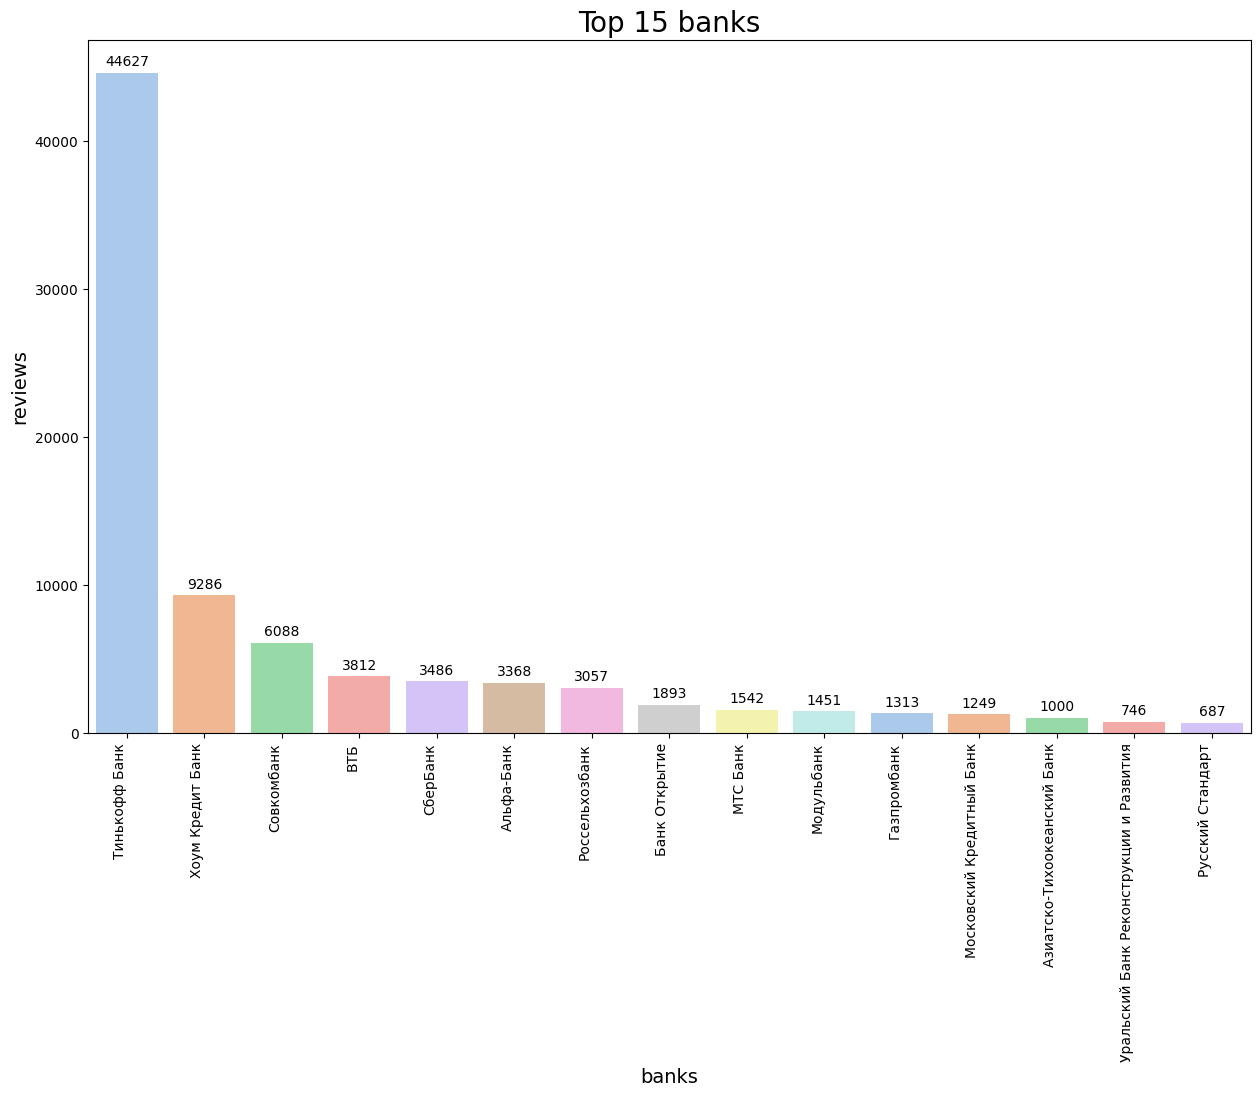

In [ ]:
top = reviews['bank_name'].value_counts().rename('counts').reset_index().sort_values(by='counts', ascending=False).head(15)

plt.figure(figsize=(15, 9))
ax = sns.barplot(x='index', y='counts', data=top, palette=sns.color_palette("pastel"))

for p in ax.patches:
    reviews_count = f'{int(p.get_height())}'
    ax.annotate(reviews_count, (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', fontsize=10, color='black', xytext=(0, 8),
                textcoords='offset points')

ax.set_xlabel('banks',fontsize=14)
ax.set_xticklabels(top['index'].values, rotation=90, ha='right')
ax.set_ylabel('reviews', fontsize=14)
ax.set_title('Top 15 banks', fontsize=20)

plt.show()

### Средний рейтинг топовых банков

Выведем средний рейтинг банков из числа топ-15

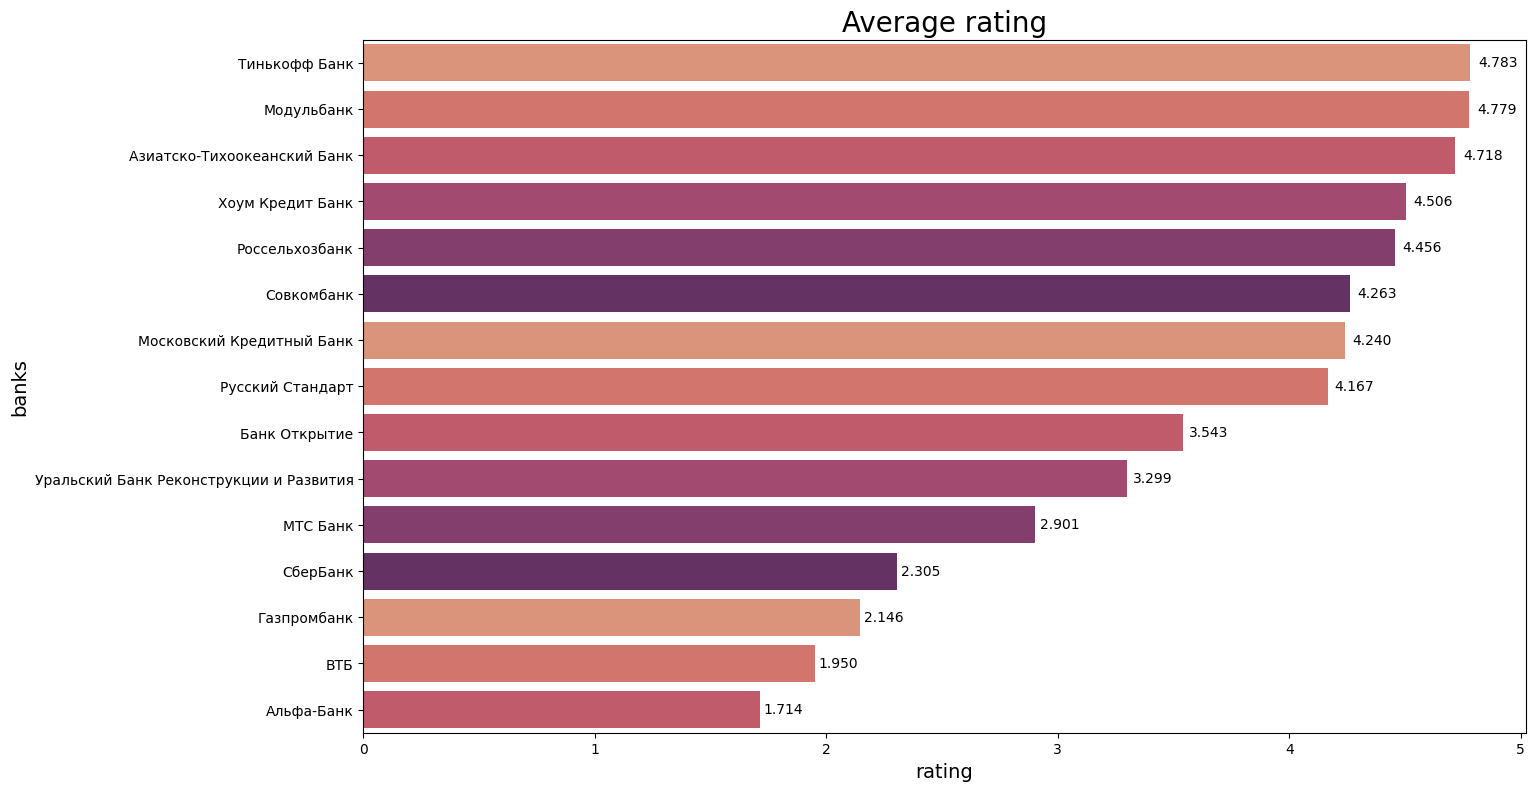

In [ ]:
avg_rating = reviews[['bank_name', 'rating']].groupby('bank_name')['rating'].mean().reset_index().rename(columns={'bank_name':'index'})
avg_rating = pd.merge(top['index'], avg_rating, on='index').sort_values(by='rating', ascending=False)

plt.figure(figsize=(15, 9))
ax = sns.barplot(x='rating', y='index', data=avg_rating, palette=sns.color_palette("flare"))

for p in ax.patches:
    avg_rating = f'{p.get_width():.3f}'
    ax.annotate(avg_rating, (p.get_width(), p.get_y() + p.get_height() / 2.),
                ha='center', va='center', fontsize=10, color='black', xytext=(p.get_width() + 15, 0),
                textcoords='offset points')

ax.set_xlabel('rating',fontsize=14)
ax.set_ylabel('banks', fontsize=14)
ax.set_title('Average rating', fontsize=20)

plt.show()

Самый большой средний рейтинг у банка Тинькофф, который еще имеет и самое большое число отзывов. На втором месте по рейтингу идет Модульбанк, который имеет гораздо меньше число отзывов.

### Динамика среднего рейтинга банков по месяцам


Рассмотрим изменение среднего рейтинга банков по месяцам из топ-5 банков по числу отзывов

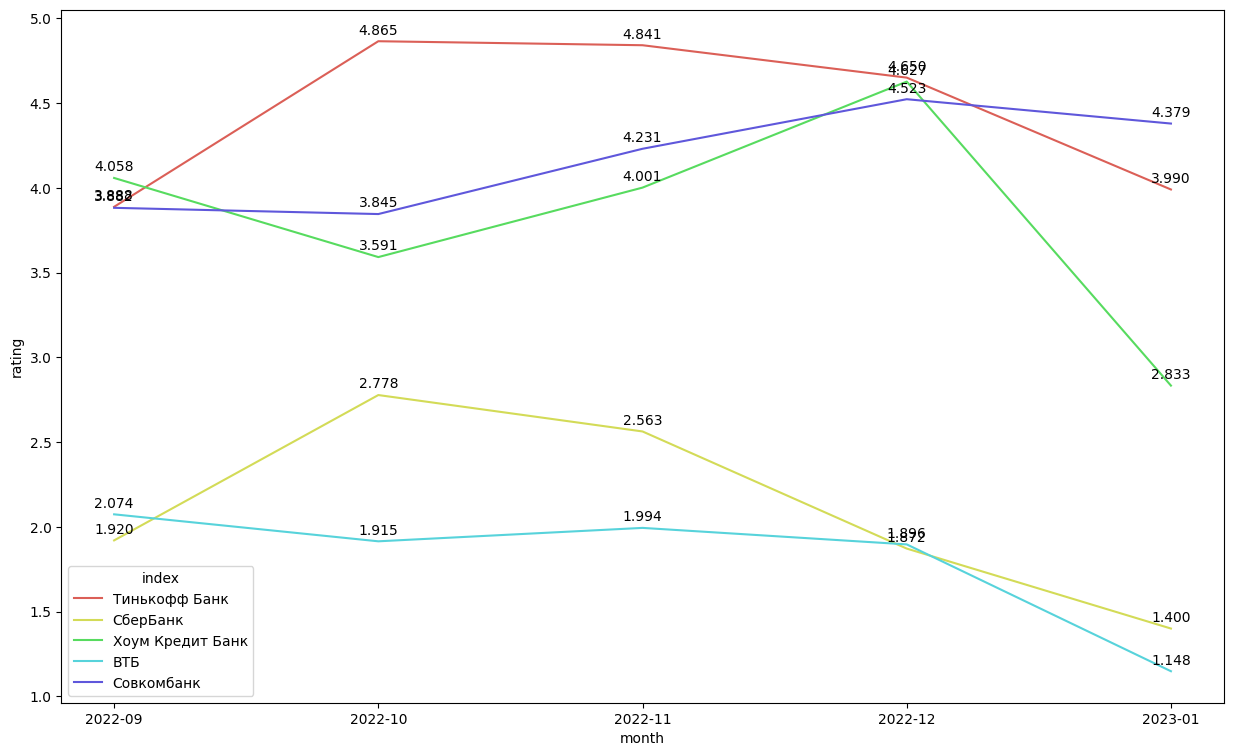

In [ ]:
avg_rating_change = (reviews[['bank_name', 'month', 'rating']]
                     .groupby(['bank_name', 'month'])['rating']
                     .mean().reset_index().rename(columns={'bank_name':'index'})
)
avg_rating_change = pd.merge(top['index'].head(5), avg_rating_change, on='index').sort_values(by='month')

plt.figure(figsize=(15, 9))
ax = sns.lineplot(x='month', y='rating', hue='index', data=avg_rating_change, palette=sns.color_palette("hls"))

for _, group in avg_rating_change.groupby('index'):
    for i in range(len(group)):
        elem = group.iloc[i]
        ax.annotate(f'{elem["rating"]:.3f}', (elem['month'], elem['rating']), fontsize = 10, \
                    textcoords="offset points", xytext=(0, 5), ha='center')

plt.show()

Из графика видно, как меняется средний рейтинг для каждого из топ-5 банков по месяцам. Можно заметить, что у всех банков с декабря по январь средний рейтинг упал (у кого-то в большей, у кого-то в меньшей степени). Можно предположить, что отзывов из января в датасете очень мало.

In [ ]:
dec_jan = (reviews[['bank_name', 'month', 'rating']]
                     .groupby(['bank_name', 'month'])['rating']
                     .count().reset_index().rename(columns={'bank_name':'index', 'rating':'reviews_count'})
          )
dec_jan = dec_jan[dec_jan['month'].isin(['2022-12', '2023-01'])]
dec_jan = pd.merge(top['index'].head(5), dec_jan, on='index').sort_values(by='month')
dec_jan

,index,month,reviews_count
0,Тинькофф Банк,2022-12,8433
2,Хоум Кредит Банк,2022-12,7732
4,Совкомбанк,2022-12,2838
6,ВТБ,2022-12,1236
8,СберБанк,2022-12,998
1,Тинькофф Банк,2023-01,103
3,Хоум Кредит Банк,2023-01,12
5,Совкомбанк,2023-01,29
7,ВТБ,2023-01,27
9,СберБанк,2023-01,25


Да, это так.

Другой какой-то общей динамики здесь наблюдать не приходится.

### Странности

Единственная странность, которая была замечена на этапе предварительного анализа $-$ полностью повторяющиеся отзывы. Дублирующиеся отзывы чаще всего единичны и близки по времени публикации. Можно предположить, что они отправлены случайно. Их мы убрали из рассмотрения.

Есть отзывы, которые имеют одинаковое содержание, но относятся к разным банкам или даже имеют разные оценки. Такие отзывы не следует убирать.

Также немного смущает количество отзывов у лидера ТОП-15 (серьезный отрыв по сравнению со вторым местом). Будем верить, что все отзывы написаны реальными клиентами.

### Зависимость положительности/отрицательности от длины отзыва

Проверим эту зависимость

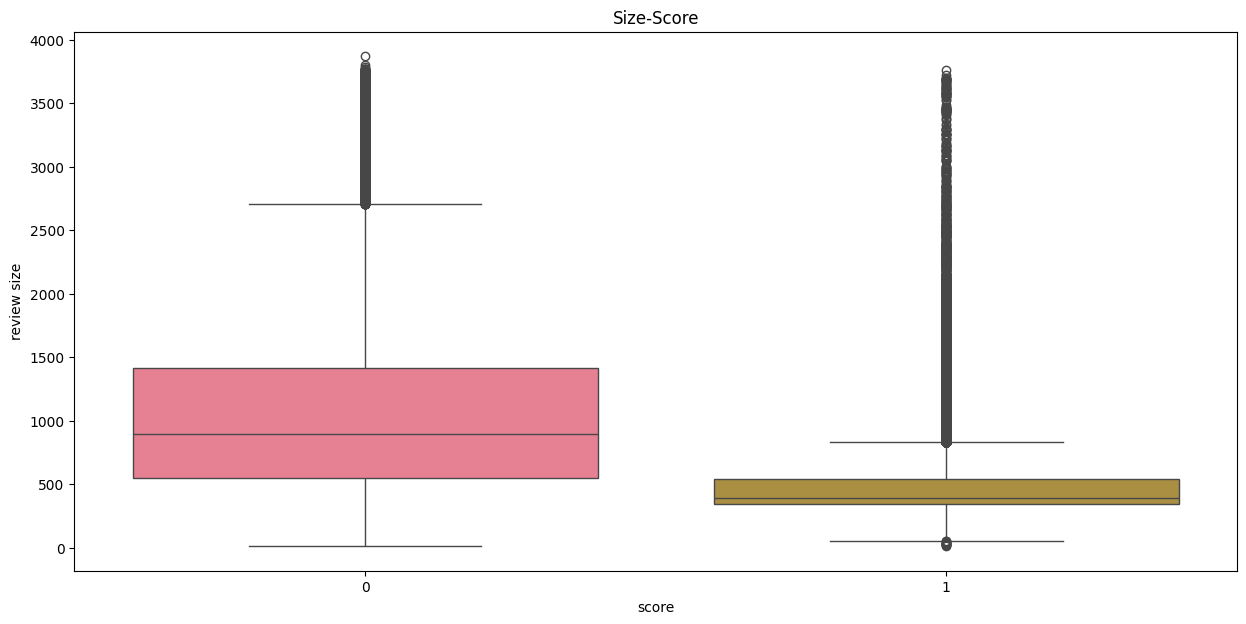

In [ ]:
plt.figure(figsize=(15,7))

sns.boxplot(x='score', y='review_size', data=reviews, palette=sns.color_palette("husl"))

plt.title('Size-Score')
plt.xlabel('score')
plt.ylabel('review size');

Да, длина отзыва сильно зависит от сентимента: положительным отзывам свойственно меньшее количество символов. Медиана у отрицательного отзыва $-$ чуть меньше 1000 символов, у положительных $-$ меньше 500. Это связано с тем, что пользователи при описании негативного опыта использования услуг банка чаще всего описывают свою проблему довольно детально. Пользователь надеется таким образом получить обратную связь от банка, решить свою проблему, если она появилась и стала причиной недовольства. Благодарности, обычно, более лаконичны.

Также наблюдается множество выбросов, но это, скорее всего, связано с тем, что датасет большой.

### Распределение отзывов по месяцам, дням недели и по времени суток

In [ ]:
reviews['month'].value_counts()

2022-12    28775
2022-11    27462
2022-10    27120
2022-09     8689
2023-01      360
Name: month, dtype: int64

Не будем рассматривать январь и сентябрь, так как они в датасете рассматриваются не полностью

In [ ]:
reviews_WOSepJan = reviews[~reviews['month'].isin(['2022-09', '2023-01'])]

Распределение отзывов по трем месяцам: октябрь, ноябрь и декабрь

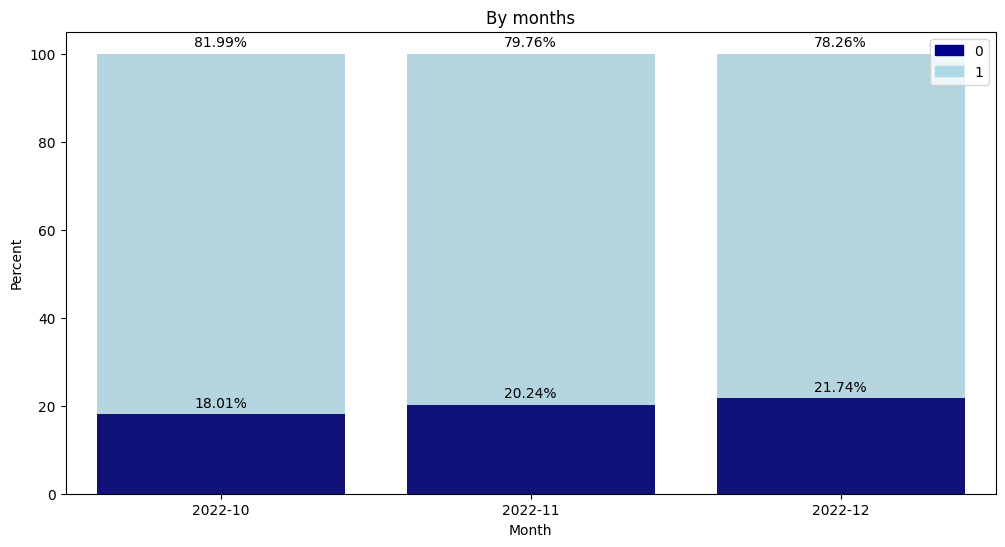

In [ ]:
months = (reviews_WOSepJan[['score', 'month']]
      .groupby(['month', 'score']).size()
      .groupby(['month'])
      .apply(lambda x: x / x.sum())
      .mul(100).reset_index(name='percent')
    )
months['total'] = 100

plt.figure(figsize=(12, 6))
sns.barplot(x='month', y='total', data=months, color='lightblue')
ax = sns.barplot(x="month",  y="percent", data=months[months['score'] == 0], color='darkblue')

for i, p in enumerate(ax.patches):
    if i < 3:
        percent = f'{(p.get_height() - ax.patches[i+3].get_height()):.2f}%'
    else:
        percent = f'{p.get_height():.2f}%'
    ax.annotate(percent, (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', color='black', xytext=(0, 8),
                textcoords='offset points')

top_bar = patches.Patch(color='darkblue', label='0')
bottom_bar = patches.Patch(color='lightblue', label='1')
plt.legend(handles=[top_bar, bottom_bar])

plt.xlabel('Month')
plt.ylabel('Percent')
plt.title('By months');

Можно сказать, что распределение по месяцам практически не меняется

Аналогично делаем по дням недели

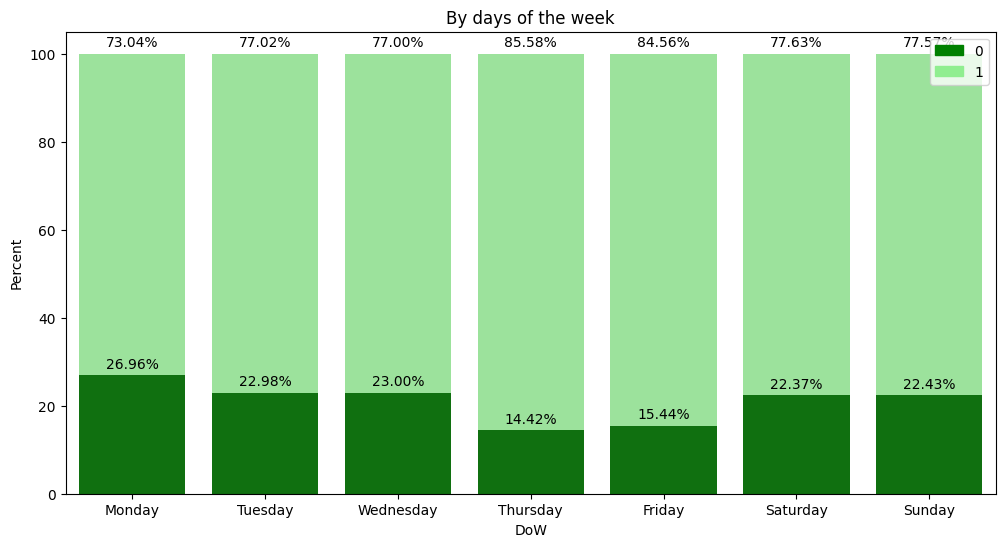

In [ ]:
dow = (reviews_WOSepJan[['score', 'dow']]
      .groupby(['dow', 'score']).size()
      .groupby(['dow'])
      .apply(lambda x: x / x.sum())
      .mul(100).reset_index(name='percent')
    )
dow['total'] = 100

week = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]

plt.figure(figsize=(12, 6))
sns.barplot(x='dow', y='total', data=dow, color='lightgreen', order=week)
ax = sns.barplot(x="dow",  y="percent", data=dow[dow['score'] == 0], order=week, color='g')

for i, p in enumerate(ax.patches):
    if i < 7:
        percent = f'{(p.get_height() - ax.patches[i+7].get_height()):.2f}%'
    else:
        percent = f'{p.get_height():.2f}%'
    ax.annotate(percent, (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', color='black', xytext=(0, 8),
                textcoords='offset points')

top_bar = patches.Patch(color='g', label='0')
bottom_bar = patches.Patch(color='lightgreen', label='1')
plt.legend(handles=[top_bar, bottom_bar])

plt.xlabel('DoW')
plt.ylabel('Percent')
plt.title('By days of the week');

Меньший процент негативных отзывов $-$ в четверг, а больший $-$ в понедельник.

Далее рассмотрим распределение отзывов по времени суток и по будням/выходным

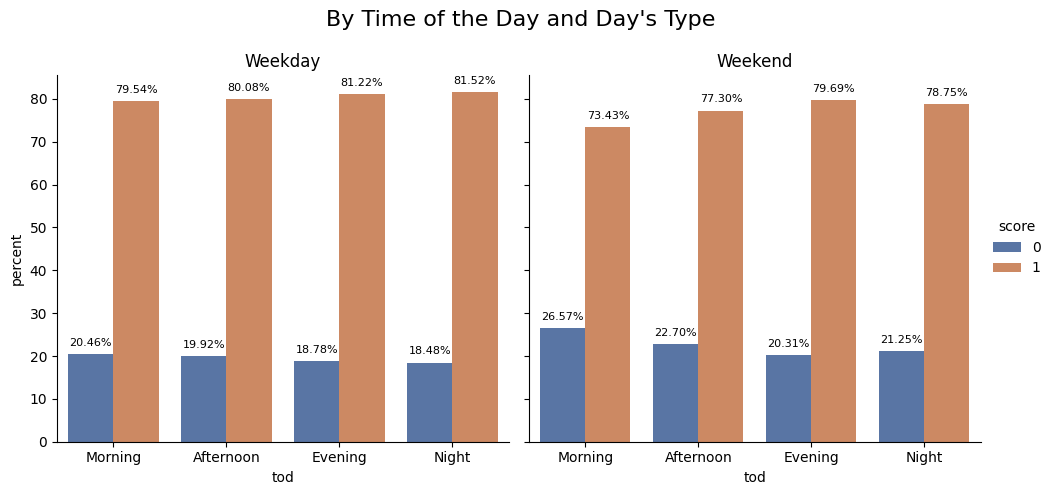

In [ ]:
tod_type = (reviews_WOSepJan[['day_type', 'tod', 'score']]
      .groupby(['day_type', 'tod', 'score']).size()
      .groupby(['day_type', 'tod'])
      .apply(lambda x: x / x.sum())
      .mul(100).reset_index(name='percent')
    )

g = sns.FacetGrid(tod_type, col="day_type", height=5)
g.map(sns.barplot, "tod", \
      "percent", "score", \
      order=["Morning", "Afternoon", "Evening", "Night"], palette="deep", errorbar=None)

g.add_legend(title='score')
plt.subplots_adjust(top=0.85)
g.fig.suptitle("By Time of the Day and Day's Type", fontsize=16)

for i, ax in enumerate(g.axes.ravel()):
    for p in ax.patches[:-2]:
        percent = f'{p.get_height():.2f}%'
        ax.annotate(percent, (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', fontsize=8, color='black', xytext=(0, 8),
                textcoords='offset points')

    ax.set_title('Weekend' if i else "Weekday")

В выходные процент отрицательных отзывов в среднем больше, но и абсолютное число отзывов в выходные меньше:

In [ ]:
reviews_WOSepJan['day_type'].value_counts()

Weekday    68710
Weekend    14647
Name: day_type, dtype: int64

Поэтому можем считать, что время слабо влияет на распределение отзывов.

Можно переходить к моделированию

## Обучение и тестирование моделей

### Препроцессинг

In [ ]:
stop_words = stopwords.words("russian")
stop_words[:10]

['и', 'в', 'во', 'не', 'что', 'он', 'на', 'я', 'с', 'со']

In [ ]:
morph = pymorphy3.MorphAnalyzer() # лемматизатор

In [ ]:
def preprocess(text, stop_words, morph):
    cleaned_text = re.sub(r'[^а-яА-Я\s]', ' ', text) # удаление всех посторонних символов кроме кириллических букв и тире
    cleaned_text = re.sub(r'[\s]+', ' ', cleaned_text) # удаление нескольких подряд идущих пробелов
    tokens = word_tokenize(cleaned_text.lower()) # токенизация
    preprocessed_text = []
    for token in tokens:
        lemma = morph.parse(token)[0].normal_form # лемматизация
        if lemma not in stop_words:
           preprocessed_text.append(lemma)
    return preprocessed_text

In [ ]:
# reviews['preprocessed_review'] = reviews['review'].apply(lambda x: preprocess(x, stop_words, morph))

Сохраним подготовленные тексты (документы)

In [ ]:
# reviews.to_csv('data/preprocessed_reviews3.csv', index=False)
reviews = pd.read_csv('data/preprocessed_reviews3.csv')

In [ ]:
reviews['preprocessed_list'] = reviews['preprocessed_review'].apply(ast.literal_eval)

In [ ]:
reviews = reviews.drop(columns=['review_size', 'date', 'month', 'dow', 'day_type', 'tod'])

In [ ]:
reviews.head(5)

,bank_name,review,rating,score,preprocessed_review,preprocessed_list
0,Еком Банк,Заблокировали средства Добрый день пишу сюда д...,1,0,"['заблокировать', 'средство', 'добрый', 'день'...","[заблокировать, средство, добрый, день, писать..."
1,Тинькофф Банк,Возврат просроченной задолженномти При возврат...,1,0,"['возврат', 'просрочить', 'задолженномть', 'во...","[возврат, просрочить, задолженномть, возврат, ..."
2,Банк Открытие,"Ошибочное начисление комиссии, затягивание про...",1,0,"['ошибочный', 'начисление', 'комиссия', 'затяг...","[ошибочный, начисление, комиссия, затягивание,..."
3,Тинькофф Банк,Клиентоориентиванность 10 из 10 Новый год начи...,5,1,"['клиентоориентиванность', 'новый', 'год', 'на...","[клиентоориентиванность, новый, год, начинатьс..."
4,Газпромбанк,Как Газпромбанк обманывает клиентов с акционны...,1,0,"['газпромбанк', 'обманывать', 'клиент', 'акцио...","[газпромбанк, обманывать, клиент, акционный, к..."


### Векторизация

Создадим словарь частот встречаемости слов

In [ ]:
words = Counter()

for review in reviews['preprocessed_list']:
    words.update(review)

len(words)

67266

In [ ]:
words.most_common(10)

[('банк', 229460),
 ('карта', 130941),
 ('это', 71627),
 ('очень', 63017),
 ('всё', 57892),
 ('тинькофф', 52141),
 ('сотрудник', 42527),
 ('который', 40061),
 ('вопрос', 39738),
 ('приложение', 39329)]

Построим словарь из 10000 наиболее часто встречающихся слов

In [ ]:
vocab_size = 10000
vocabulary = dict()
for i, word in enumerate(words.most_common(vocab_size)):
    vocabulary[word[0]] = i

Переходим к векторизации. Будем использовать стандартную модель $TF_{t,d} \times IDF_d$

In [ ]:
vectorizer = TfidfVectorizer(use_idf=True, vocabulary=vocabulary)
X = vectorizer.fit_transform(reviews['preprocessed_review'].values) # в разреженном виде

In [ ]:
X.shape[0]

92406

In [ ]:
X[0]

<1x10000 sparse matrix of type '<class 'numpy.float64'>'
	with 41 stored elements in Compressed Sparse Row format>

In [ ]:
X[0].A

array([[0.03105684, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

### Разделение на трейн и тест

У нас дисбаланс классов, поэтому примем некоторые меры при разделении (стратификация)

In [ ]:
train, test = train_test_split(np.arange(X.shape[0])
                              ,test_size=0.2
                              ,stratify=reviews[['score', 'rating']] # одинковое распределение по score и по rating
                              ,random_state=423248798) # для воспроизводимости

In [ ]:
X_train = X[train]
y_train = reviews.score.values[train]

In [ ]:
X_test = X[test]
y_test = reviews.score.values[test]

### Логиcтическая регрессия (baseline)

Логистическая регрессия $-$ простая модель для классификации. Ее хорошо использовать в качестве baseline-модели для сравнения с более сложными алгоритмами

In [ ]:
lr = LogisticRegression(class_weight='balanced',  # веса классов, обратно пропорциональны частоте классов
                        max_iter=1000)
lr.fit(X_train, y_train)

LogisticRegression(class_weight='balanced', max_iter=1000)

Будем проверять модель с помощью метрик классификации (accuracy, precision, recall, f1-score)

In [ ]:
lr_pred=lr.predict(X_test)
print(classification_report(y_test, lr_pred, digits=4))

              precision    recall  f1-score   support

           0     0.8944    0.9846    0.9374      4164
           1     0.9954    0.9662    0.9806     14318

    accuracy                         0.9703     18482
   macro avg     0.9449    0.9754    0.9590     18482
weighted avg     0.9726    0.9703    0.9708     18482



Получены очень хорошие результаты.

Остальные модели будем проверять по метрике $f1$-score

In [ ]:
results = {} # сюда будем сохранять результаты метрик
results['LR'] = {'0-score' : 0.9374, '1-score' : 0.9806}

Посмотрим на матрицу ошибок

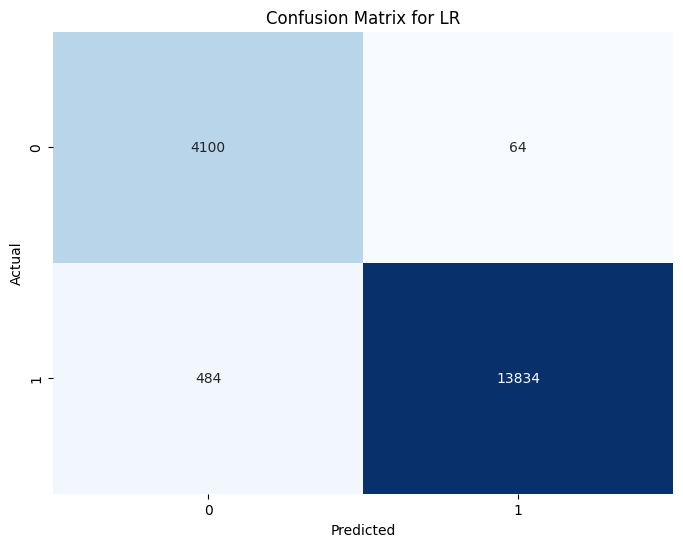

In [ ]:
conf_matrix = confusion_matrix(y_test, lr_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=lr.classes_, yticklabels=lr.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for LR')
plt.show()

Также посмотрим на $ROC$-кривую и площадь под ней

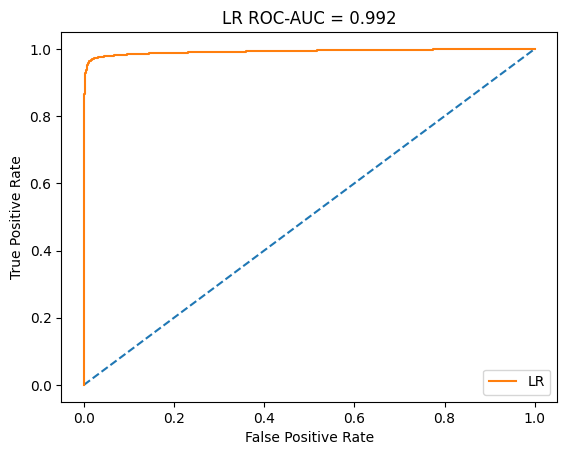

In [ ]:
lr_score = lr.predict_proba(X_test)[:,1]
fpr, tpr, _ = roc_curve(y_test, lr_score)

plt.figure()
plt.plot([0, 1], linestyle='--')
plt.plot(fpr, tpr, label='LR')
plt.title('LR ROC-AUC = %0.3f' % roc_auc_score(y_test, lr_score))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc='lower right')
plt.show()

### CatBoost

CatBoost является популярной реализацией градиентного бустинга. Хорошо будет сравнить его с ЛР

In [ ]:
# catboost_model = CatBoostClassifier(iterations=500, eval_metric="F1")
train_pool = Pool(X_train, y_train)

In [ ]:
# здесь должен был быть GridSearch, но у коллаба кончились ресурсы
# param_grid = {
#     'learning_rate': [0.01, 0.03],
#     'depth': [4, 6],
# }
# grid_search = catboost_model.grid_search(param_grid,
#                                          train_pool,
#                                          cv=3, stratified=True,
#                                          verbose=False, plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8729153	test: 0.8708075	best: 0.8708075 (0)	total: 846ms	remaining: 7m 2s
1:	learn: 0.8793492	test: 0.8775914	best: 0.8775914 (1)	total: 1.44s	remaining: 5m 58s
2:	learn: 0.8823770	test: 0.8808553	best: 0.8808553 (2)	total: 2.03s	remaining: 5m 36s
3:	learn: 0.8824910	test: 0.8808363	best: 0.8808553 (2)	total: 2.63s	remaining: 5m 26s
4:	learn: 0.9025008	test: 0.9004186	best: 0.9004186 (4)	total: 3.21s	remaining: 5m 17s
5:	learn: 0.9026173	test: 0.9007823	best: 0.9007823 (5)	total: 3.9s	remaining: 5m 20s
6:	learn: 0.9225263	test: 0.9213186	best: 0.9213186 (6)	total: 4.49s	remaining: 5m 16s
7:	learn: 0.9176807	test: 0.9157464	best: 0.9213186 (6)	total: 5.07s	remaining: 5m 11s
8:	learn: 0.9258178	test: 0.9238511	best: 0.9238511 (8)	total: 5.7s	remaining: 5m 11s
9:	learn: 0.9210630	test: 0.9200132	best: 0.9238511 (8)	total: 6.26s	remaining: 5m 7s
10:	learn: 0.9183951	test: 0.9162678	best: 0.9238511 (8)	total: 6.83s	remaining: 5m 3s
11:	learn: 0.9138952	test: 0.9134217	best: 0.92

In [ ]:
catboost_model = CatBoostClassifier(iterations=1000, eval_metric="F1", learning_rate=0.03, depth=6)
# catboost_model.fit(train_pool)

0:	learn: 0.9077950	total: 2.73s	remaining: 45m 24s
1:	learn: 0.9215704	total: 4.05s	remaining: 33m 41s
2:	learn: 0.9229938	total: 5.37s	remaining: 29m 45s
3:	learn: 0.9214094	total: 6.69s	remaining: 27m 46s
4:	learn: 0.9234517	total: 7.93s	remaining: 26m 18s
5:	learn: 0.9318331	total: 9.17s	remaining: 25m 19s
6:	learn: 0.9341176	total: 10.4s	remaining: 24m 28s
7:	learn: 0.9326849	total: 11.5s	remaining: 23m 52s
8:	learn: 0.9318692	total: 13.5s	remaining: 24m 51s
9:	learn: 0.9331606	total: 15.7s	remaining: 25m 51s
10:	learn: 0.9322806	total: 17.6s	remaining: 26m 24s
11:	learn: 0.9330614	total: 19s	remaining: 26m 6s
12:	learn: 0.9336441	total: 20.3s	remaining: 25m 41s
13:	learn: 0.9348278	total: 21.6s	remaining: 25m 23s
14:	learn: 0.9355539	total: 22.8s	remaining: 24m 59s
15:	learn: 0.9362287	total: 24s	remaining: 24m 38s
16:	learn: 0.9362677	total: 25.3s	remaining: 24m 21s
17:	learn: 0.9362754	total: 26.5s	remaining: 24m 3s
18:	learn: 0.9362959	total: 27.6s	remaining: 23m 46s
19:	learn

In [ ]:
# catboost_model.save_model('CB_model_1801')
catboost_model.load_model('CB_model_1801')

In [ ]:
catboost_pred=catboost_model.predict(X_test)
print(classification_report(y_test, catboost_pred, digits=4))

              precision    recall  f1-score   support

           0     0.9223    0.9179    0.9201      4164
           1     0.9761    0.9775    0.9768     14318

    accuracy                         0.9641     18482
   macro avg     0.9492    0.9477    0.9485     18482
weighted avg     0.9640    0.9641    0.9640     18482



In [ ]:
# запротоколируем результат
results['CatBoost'] = {'0-score' : 0.9201, '1-score' : 0.9768}

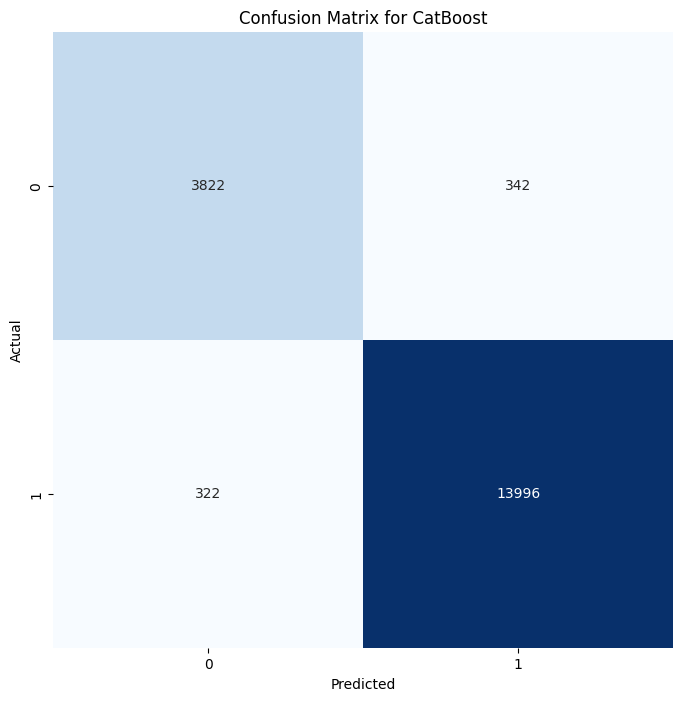

In [ ]:
conf_matrix = confusion_matrix(y_test, catboost_pred)

plt.figure(figsize=(8, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=catboost_model.classes_, yticklabels=catboost_model.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for CatBoost')
plt.show();

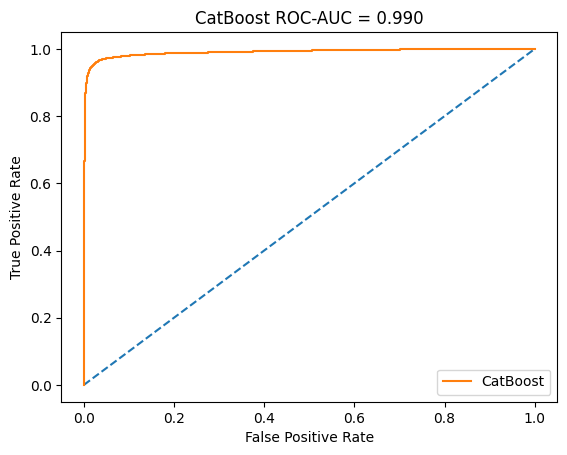

In [ ]:
catboost_score = catboost_model.predict_proba(X_test)[:,1]
fpr, tpr, _ = roc_curve(y_test, catboost_score)

plt.figure()
plt.plot([0, 1], linestyle='--')
plt.plot(fpr, tpr, label='CatBoost')
plt.title('CatBoost ROC-AUC = %0.3f' % roc_auc_score(y_test, catboost_score))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc='lower right')
plt.show()

### Результаты

In [ ]:
pd.DataFrame(results).style.highlight_max(axis=1, color='darkblue')

,LR,CatBoost
0-score,0.937400,0.920100
1-score,0.980600,0.976800


**Выводы**:
1. *Логистическая регрессия* очень хороша в простых задачах. Не требуется подбор параметров. На вход она получает простую векторную модель по типу BoW или TF-IDF, а на выходе $-$ неплохой прогноз, высокие метрики. Единственное, что не здорово $-$ размер векторных представлений должен быть большим при большом корпусе. Далее рассмотрю подход снижения размерности векторного пространства.

2. *Градиентный бустинг* обязательно должен превзойти ЛР при правильном подборе параметров (особенно просто это сделать с GridSearch, который почему-то в коллабе не завершился ни с какой попытки, гпу тоже не работает). Даже простое увеличение числа деревьев должно помочь. Но подбор параметров $-$ дело долгое и ресурсоемкое. Для решения сложных задач, скорее всего, никакая логистическая регрессия не поможет, а поможет GB и достаточное количество ресурсов.

## Снижение размерности признакового пространства

Получим веса признаков, подобранные логистической регрессией (веса для каждого компонента вектора TF-IDF)

In [ ]:
feature_importance = pd.DataFrame({'words': vectorizer.get_feature_names_out(),
                                  'weights': lr.coef_.flatten()})

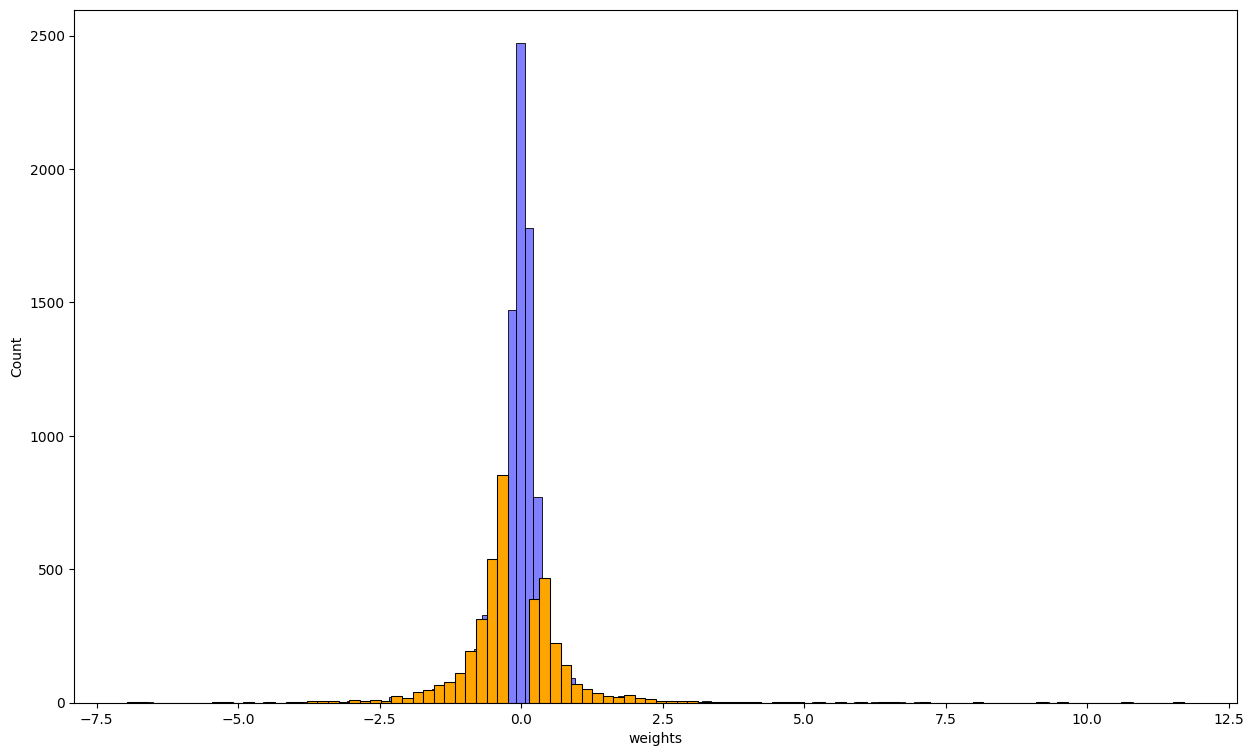

In [ ]:
all_imp = feature_importance[feature_importance['weights'] != 0]

fig, ax = plt.subplots(figsize=(15, 9))

sns.histplot(all_imp['weights'], bins=125, alpha=0.5, color='blue', ax=ax)
sns.histplot(all_imp.query('weights > 0.25 or weights < -0.25')['weights'], bins=100, alpha=1, color='orange', ax=ax)
plt.show();

Большинство слов имеет малый вес (в интервале $[-0.25, 0.25]$). Посмотрим, что за слова

In [ ]:
often_words = all_imp.query('weights <= 0.25 and weights >= -0.25')['words']
often_words

7            который
19              свой
24         кредитный
25             время
28           условие
            ...     
9995    трудолюбивый
9996         изымать
9997        отыскать
9998       иждивение
9999       тупиковый
Name: words, Length: 6085, dtype: object

Наоборот, значимые слова

In [ ]:
important_words = all_imp.query('weights > 0.25 or weights < -0.25')['words']
important_words

0                банк
1               карта
2                 это
3               очень
4                 всё
            ...      
9935      традиционно
9951              итб
9962    независимость
9989      красоваться
9990           подожд
Name: words, Length: 3897, dtype: object

Получим их векторые представления

In [ ]:
vectorizer = TfidfVectorizer(use_idf=True, vocabulary=important_words)
X = vectorizer.fit_transform(reviews['preprocessed_review'].values)

In [ ]:
# это новая длина векторного представления документа
# а старая - 10000
X[0].shape[1]

3897

Снова обучим логистическую регрессию

In [ ]:
train, test = train_test_split(np.arange(X.shape[0])
                              ,test_size=0.2
                              ,stratify=reviews[['score', 'rating']]
                              ,random_state=423248798)

In [ ]:
X_train = X[train]
y_train = reviews.score.values[train]

In [ ]:
X_test = X[test]
y_test = reviews.score.values[test]

In [ ]:
lr_new = LogisticRegression(class_weight='balanced', max_iter=1000)
lr_new.fit(X_train, y_train)

LogisticRegression(class_weight='balanced', max_iter=1000)

Посчитаем новые скоры

In [ ]:
print(classification_report(y_test, lr_new.predict(X_test), digits=4))

              precision    recall  f1-score   support

           0     0.8962    0.9846    0.9383      4164
           1     0.9954    0.9668    0.9809     14318

    accuracy                         0.9708     18482
   macro avg     0.9458    0.9757    0.9596     18482
weighted avg     0.9730    0.9708    0.9713     18482



И сравним со старыми

In [ ]:
results['LR']

{'0-score': 0.9374, '1-score': 0.9806}

Получилось так, что новый прогноз по $f1$ оказался даже лучше старого (!!!)

Отсюда можно сделать вывод, что применение feature selection и, соответственно, снижение размерности признакового пространства в подобного рода задачах необходим

## Характерные признаки для классов

Признаки, которые характерны для положительных отзывов

In [ ]:
max_imp = feature_importance.sort_values(by='weights', ascending = False)
max_imp.head(15)

,words,weights
30,спасибо,11.714701
26,быстро,10.747865
77,благодарность,9.476420
11,хороший,9.278626
5,тинькофф,7.991145
34,удобный,7.172302
85,довольный,7.077359
3,очень,6.638998
36,помочь,6.513923
63,отличный,6.317628


Признаки, которые вносят отрицательный вклад (говоря об отрицательности отзыва)

In [ ]:
min_imp = feature_importance.sort_values(by='weights')
min_imp.head(15)

,words,weights
374,обман,-6.957942
625,отвратительный,-6.635724
611,ужасный,-6.634309
232,никто,-5.460712
181,просить,-5.256391
128,говорить,-4.758232
304,отказ,-4.461858
979,обманывать,-3.995888
87,ваш,-3.961839
580,видимо,-3.779954


Визуализация значимых признаков (слов) для каждого класса

In [ ]:
pos_values = max_imp.values[:100]
img_positive = WordCloud(background_color="white", colormap="Greens", max_words=200, \
                                 width=1500, height=1500) \
                                .generate_from_frequencies(dict(pos_values))
neg_values = min_imp.values[:100]
neg_values[:, 1] = -1 * neg_values[:, 1]
img_negative = WordCloud(background_color="black", colormap="Reds", max_words=200, \
                                 width=1500, height=1500) \
                                .generate_from_frequencies(dict(neg_values))

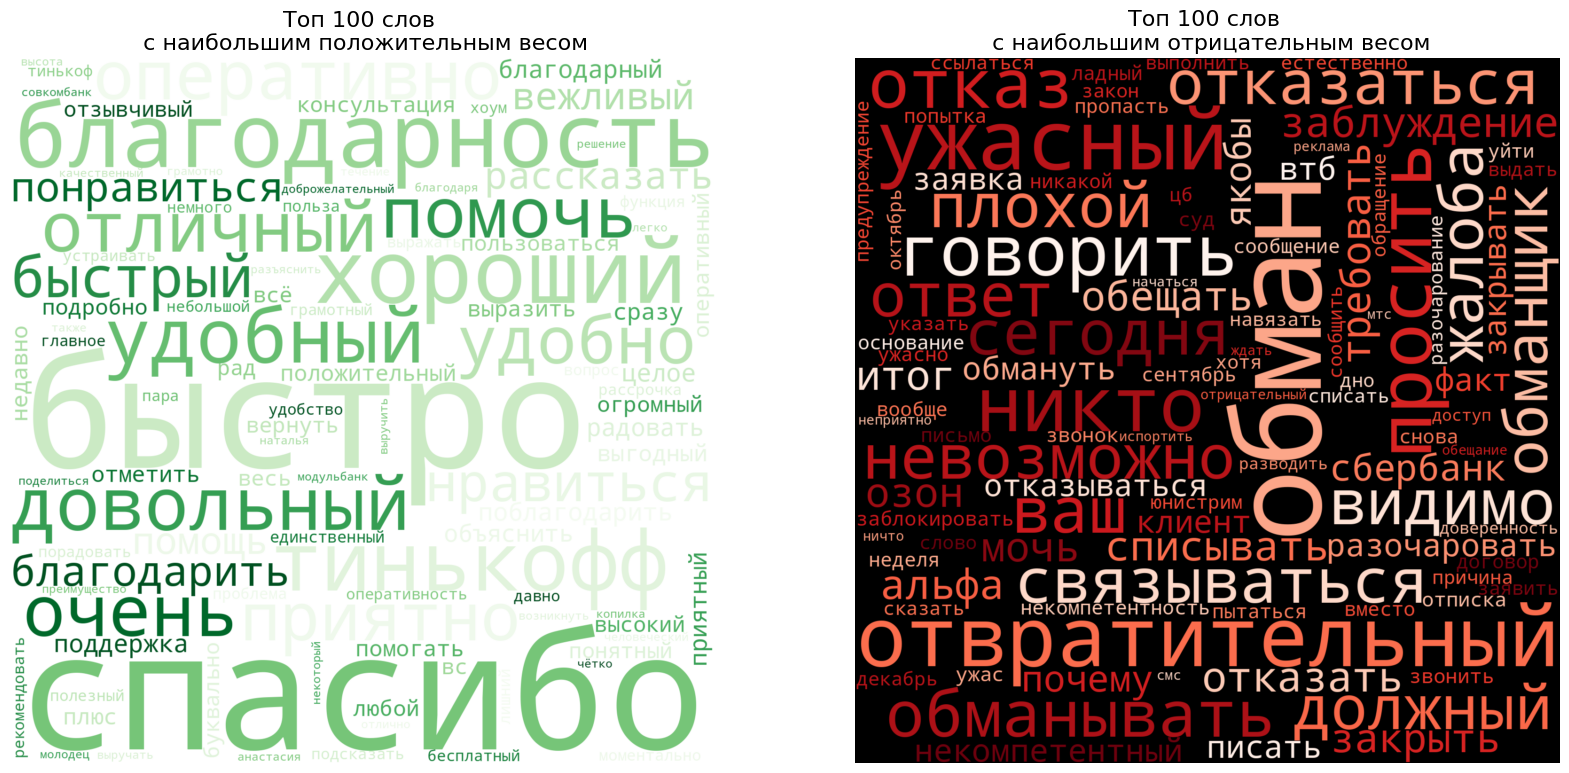

In [ ]:
fig, axs = plt.subplots(1, 2, figsize = (20, 12))

axs[0].imshow(img_positive, interpolation='bilinear')
axs[0].set_title('Топ 100 слов \n с наибольшим положительным весом', fontsize = 16)
axs[0].axis(False)

axs[1].imshow(img_negative, interpolation='bilinear')
axs[1].set_title('Топ 100 слов \n с наибольшим отрицательным весом', fontsize = 16)
axs[1].axis(False)

plt.show();

Чем важнее слово, тем оно больше на рисунках